In [13]:
import networkx as nx
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [14]:
CSS_graph = nx.read_graphml('my_data/CSS_graph.graphml')

In [15]:
def get_matching_att(graph, att):
    match_frac = {}
    for node in graph.nodes:
        counter = 0
        neighbors = len(list(graph.neighbors(node)))

        if neighbors == 0: match_frac[node] = 0

        else:
            for neighbor in graph.neighbors(node):
                if nx.get_node_attributes(graph, att)[neighbor] == nx.get_node_attributes(graph, att)[node]:
                    counter += 1

            match_frac[node] = counter / neighbors

    return match_frac

In [16]:
top_field_fracs = get_matching_att(CSS_graph, 'att2')

In [190]:
print(f"Average across all nodes {np.mean(list(top_field_fracs.values()))}")

average across all nodes 0.3559081424843902


#### 1.2 Shuffle the top fields

In [5]:
CSS_graph_copy = nx.read_graphml('my_data/CSS_graph.graphml')

In [6]:
def shuffle_node_att(graph, att):
    shuffled_atts = nx.get_node_attributes(graph, att)
    temp = list(shuffled_atts.values())
    random.shuffle(temp)
    new_atts = dict(zip(shuffled_atts, temp))

    return new_atts

In [60]:
#Shuffle the top fields:
nx.set_node_attributes(CSS_graph_copy, shuffle_node_att(CSS_graph, 'att2'), 'att2')

In [7]:
def sim_matching_atts(graph, att, N, copy):
    sim_matrix = []
    for i in tqdm(range(N)):
        nx.set_node_attributes(copy, shuffle_node_att(graph, att), att)
        sim_matrix.append(list(get_matching_att(copy, att).values()))
    return sim_matrix

### 1.3 Repeat the above atleast 100 times and plot the distribution

In [9]:
# Simulate 100 graphs with random fields
# Takes about N*2.5min to run
#sim_matrix = sim_matching_atts(CSS_graph, 'att2', 300, CSS_graph_copy)
#np.save("sim_matrix", sim_matrix)

100%|██████████| 300/300 [13:12:58<00:00, 158.60s/it]  


In [11]:
#Load sim results
sim_matrix = np.load('sim_matrix.npy')

(array([ 13.73177114,  27.46354228,  44.6282562 ,  73.80826987,
        115.00358329,  96.12239797,  85.82356962,  34.32942785,
         15.44824253,   8.58235696]),
 array([0.27025986, 0.27220183, 0.27414379, 0.27608576, 0.27802773,
        0.2799697 , 0.28191167, 0.28385364, 0.2857956 , 0.28773757,
        0.28967954]),
 <BarContainer object of 10 artists>)

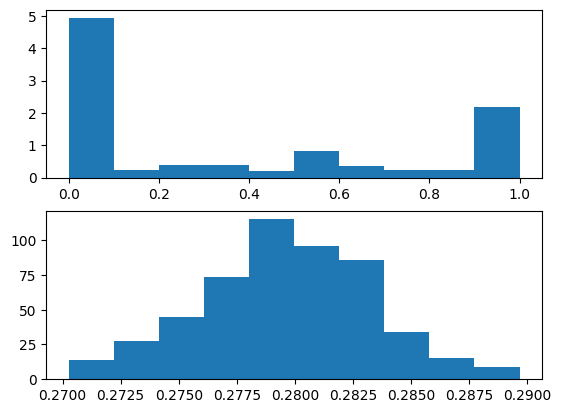

In [17]:
#plot distribution for real and sim graphs
sim_vector = [np.mean(sublist) for  sublist in sim_matrix]
figure, ax = plt.subplots(2)
bins = 10

ax[0].hist(top_field_fracs.values(), density=True, bins = bins)
ax[1].hist(sim_vector, density=True, bins = bins)

### TODO interprete the the plots

#### 1.4 Compute the assortativity coefficient for the network, with respect to author field

In [162]:
E = {}
list_of_fields =list(set(nx.get_node_attributes(CSS_graph, 'att2').values()))

for field in list_of_fields:
    E[field] = {}
    for field2 in list_of_fields:
        E[field][field2] = 0

for node in tqdm(CSS_graph.nodes):
    node_field = nx.get_node_attributes(CSS_graph, 'att2')[node]

    for neighbor in nx.neighbors(CSS_graph, node):
        neighbor_field = nx.get_node_attributes(CSS_graph, 'att2')[neighbor]
        E[node_field][neighbor_field] +=1


for field in list_of_fields:
    for field2 in list_of_fields:
        #number_in_field = nx.get_node_attributes()
        E[field][field2] = E[field][field2]/(2 * CSS_graph.number_of_edges())


100%|██████████| 10727/10727 [01:40<00:00, 106.72it/s]


In [163]:
#Hvis man ikke vil lave en masse forloop
#E_nx = nx.attribute_mixing_matrix(CSS_graph, attribute='att2')

In [164]:
#Check of the E matrix to see if it upholds that sum(e_{i,j}) = 1
# And make the dict to a matrix
s = 0
matrix_E = []
for field in list_of_fields:
    matrix_E.append(list(E[field].values()))
    for field2 in E[field].keys():
        s += E[field][field2]
s

1.000000000000002

In [165]:
for sublist1, sublist2 in zip(E_nx, matrix_E):
    if not np.any(sublist1 == sublist2):
        print('Deviation')


In [166]:
A = B = [sum(sublist) for sublist in matrix_E]

In [170]:
assortative_coefficient = (sum(np.diagonal(matrix_E)) - sum(np.array(A) * np.array(B))) / (1 - sum(np.array(A) * np.array(B)))

print(f"The assortive coeffiecnt is: {assortative_coefficient}. Using the NetworkX method we get {nx.attribute_assortativity_coefficient(CSS_graph, 'att2')}")
print("Check if they are the same:", assortative_coefficient == nx.attribute_assortativity_coefficient(CSS_graph, 'att2'))

The assortive coeffiecnt is: 0.19011838960820351. Using the NetworkX method we get 0.19011838960820351
Check if they are the same: True


#### 1.5 Graph assortativity with regards to degree

In [180]:
E_degree = {}
threshold = 10
degrees = ['High', 'Low']

for degree1 in degrees:
    E_degree[degree1] = {}
    for degree2 in degrees:
        E_degree[degree1][degree2] = 0

for node in tqdm(CSS_graph.nodes):
    node_degree = nx.degree(CSS_graph, node)
    if node_degree > threshold: node_degree = 'High'
    else: node_degree = 'Low'
    for neighbor in nx.neighbors(CSS_graph, node):
        neighbor_degree = nx.degree(CSS_graph, neighbor)

        if neighbor_degree > threshold: neighbor_degree = 'High'
        else: neighbor_degree = 'Low'

        E_degree[node_degree][neighbor_degree] +=1


for degree1 in degrees:
    for degree2 in degrees:
        E_degree[degree1][degree2] = E_degree[degree1][degree2]/(2 * CSS_graph.number_of_edges())


100%|██████████| 10727/10727 [00:00<00:00, 338008.41it/s]


In [181]:
#Create maxtrix and calc A and B
matrix_E_degree = []
for degree in degrees:
    matrix_E_degree.append(list(E[degree].values()))

A_degree = B_degree = [sum(sublist) for sublist in matrix_E_degree]

In [183]:
assortative_coefficient = (sum(np.diagonal(matrix_E_degree)) - sum(np.array(A_degree) * np.array(B_degree))) / (1 - sum(np.array(A_degree) * np.array(B_degree)))

print(f"The assortive coeffiecnt is: {assortative_coefficient}")

The assortive coeffiecnt is: 2.073105685192636e-05


### TODO interprete the answer